In [51]:
import sys
import os
import numpy as np

from astropy.io import ascii as asc
import astropy.units as u
from astropy.table import Table

from matplotlib import pyplot as plt
%matplotlib inline
from utilities_az import supernova

sys.path.append('/Users/bostroem/Desktop/research/not_my_code/SNEC-1.01/')
import chisq_analysis

In [2]:
plt.style.use('az-paper-onecol')
FIG_DIR = '../figures/'

# \#1

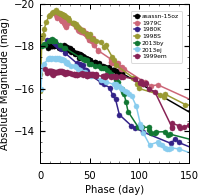

In [17]:
sn_list = ['asassn-15oz', '1979C', '1980K', '1998S', '2013by', '2013ej', '1999em']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for snname in sn_list:
    sn = supernova.LightCurve2(snname)
    sn.get_photometry()
    sn.get_abs_mag()
    sort_indx = np.argsort(sn.phase['V'])
    ax.plot(sn.phase['V'][sort_indx], sn.abs_mag['V'][sort_indx], marker='o', label=snname)
ax.invert_yaxis()
ax.set_xlim(0, 150)
ax.set_ylim(-12.5, -20)  
ax.legend()
ax.set_xlabel('Phase (day)')
ax.set_ylabel('Absolute Magnitude (mag)')
plt.savefig(os.path.join(FIG_DIR, 'snIIL_LC_comp.pdf'))

# \#13.1 Pre-SN radius 

In [46]:
masses = [11, 13, 14, 16, 17, 18, 21]
for m in masses:
    tbdata = asc.read('../../not_my_code/SNEC-1.01/sukhbold_profiles/s{}/profiles/s{}.0.short'.format(m, m), data_start=1)
    print('{:2.1f}*100 for mass {}'.format((tbdata['col3'][-1]*u.cm).to(u.Rsun)/100, m))

5.7 solRad*100 for mass 11
7.0 solRad*100 for mass 13
7.8 solRad*100 for mass 14
8.9 solRad*100 for mass 16
9.1 solRad*100 for mass 17
9.7 solRad*100 for mass 18
11.2 solRad*100 for mass 21


# \#13.2

In [41]:
ni_mass = [0.083, 0.0965, 0.11]
energies = [0.5, 0.8, 1.1, 1.4, 1.7, 2.0]
masses = [11, 13, 15, 16, 17, 18, 21]
ni_mixing = [5.0]
time_offsets = np.arange(-4, 4, 1)
Kvalues = [10, 20, 30, 35, 40, 50, 60]
radii = [1500, 1800, 2100, 2400, 2700, 3000, 3300]

snec_models = '/Users/bostroem/dark/SNEC/snec_models/'
snname = 'asassn15oz'
S2_start = 50
S2_end = 88  #Vary this parameter

best_model_csm_dir = os.path.join(snec_models, 
                                 'Ni_mass_{:1.4f}'.format(0.083),
                                 'Ni_mixing_{:1.1f}'.format(5.0),
                                 'M{:2.1f}'.format(18.0),
                                 'E_{:1.3f}'.format(1.400),
                                 'K_{:2.1f}'.format(10.0), 
                                 'R_{}'.format(2400),
                                 'Data')
snec_15oz = chisq_analysis.SnecAnalysis(snname, snec_models, S2_start, S2_end, 
                 ni_mass, ni_mixing, masses, energies, time_offsets, 
                 Kvalues, radii, fig_dir='../figures')
print(best_model_csm_dir)

/Users/bostroem/dark/SNEC/snec_models/Ni_mass_0.0830/Ni_mixing_5.0/M18.0/E_1.400/K_10.0/R_2400/Data


In [35]:
mod_tbdata_obs = asc.read(os.path.join(best_model_csm_dir, 'lum_observed.dat'), names=['time', 'luminosity'])
mod_tbdata_obs['time'] = ((mod_tbdata_obs['time']-snec_15oz.get_breakout_time(best_model_csm_dir))*u.s).to(u.day).value
mod_tbdata_phot = asc.read(os.path.join(best_model_csm_dir, 'lum_photo.dat'), names=['time', 'luminosity'])
mod_tbdata_phot['time'] = ((mod_tbdata_phot['time']-snec_15oz.get_breakout_time(best_model_csm_dir))*u.s).to(u.day).value

In [36]:
pseudo_bolo_lum = asc.read('../data/asassn15oz_bolo_UBgVrRiI.txt', names=['phase', 'luminosity', 'error'], format='commented_header')

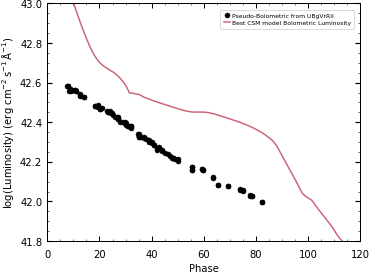

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(pseudo_bolo_lum['phase'], pseudo_bolo_lum['luminosity'], 'o', label='Pseudo-Bolometric from UBgVrRiI')
ax.plot(mod_tbdata_phot['time'][mod_tbdata_phot['time']>7], np.log10(mod_tbdata_phot['luminosity'][mod_tbdata_phot['time']>7]), label='Best CSM model Bolometric Luminosity')
ax.legend()
ax.set_xlabel('Phase')
ax.set_xlim(0, 120)
ax.set_ylim(41.8, 43)
ax.set_ylabel(r'log(Luminosity) (erg $\rm cm^{-2}\,s^{-1}\,\AA^{-1}$)')
plt.savefig(os.path.join(FIG_DIR, 'model_obs_bolometric_L_comp.pdf'))

In [54]:
tbdata = Table([mod_tbdata_phot['time'][mod_tbdata_phot['time']>7], np.log10(mod_tbdata_phot['luminosity'][mod_tbdata_phot['time']>7])], names=['Time(day)', 'log10(lum)'])
tbdata.write('../data/snec_bolo_lum.csv', format='ascii.commented_header', delimiter=',', overwrite=True)